In [1]:
import os
import re
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from visturing.properties.prop8 import load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, prepare_and_correlate_order, calculate_spearman, calculate_pearson_stack

In [3]:
root_path = "../../Data/Experiment_9"

In [4]:
import scipy
exp8_low = scipy.io.loadmat('resp_legge_energy_3.mat')
exp8_high = scipy.io.loadmat('resp_legge_energy_12.mat')

xs = exp8_high["C"][0]
xs.shape

(20,)

In [5]:
data_high = {re.findall("high_(\w+)\.", p)[0]: np.load(p) for p in glob(os.path.join(root_path, "*")) if "high" in p}
for k, v in data_high.items(): print(k, v.shape)

achrom (6, 20, 256, 256, 3)


In [6]:
data_low = {re.findall("low_(\w+)\.", p)[0]: np.load(p) for p in glob(os.path.join(root_path, "*")) if "low" in p}
for k, v in data_low.items(): print(k, v.shape)

achrom (6, 20, 256, 256, 3)


In [7]:
f_mask = ['No mask', 'F_mask = 1.5 cpd', 'F_mask = 3 cpd', 'F_mask = 6 cpd', 'F_mask = 12 cpd', 'F_mask = 24 cpd']

In [14]:
# for name, chroma in data.items():
#     for dat in chroma:
#         fig, axes = plt.subplots(1,len(dat))
#         for ax, d in zip(axes.ravel(), dat):
#             ax.imshow(d)
#             ax.axis("off")
#         plt.show()

In [8]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import Baseline as PerceptNet
from paramperceptnet.configs import param_config

In [9]:
model_name = "ppnet-baseline"

In [10]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [11]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
params = variables["params"]

In [12]:
model = PerceptNet(config)

In [13]:
params.keys()

dict_keys(['Color', 'Conv_0', 'Conv_1', 'GDN_0', 'GDN_1', 'GDN_2', 'GDN_3'])

In [14]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDN_3"]["__call__"][0]
    b = extra_b["intermediates"]["GDN_3"]["__call__"][0]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [15]:
def obtain_results(data):
    diffs = defaultdict(dict)
    for name, chroma in data.items():
        for f, dat in zip(f_mask, chroma):
            diffs_ = calculate_diffs(dat, dat[0:1])
            diffs[name][f] = diffs_
    return diffs

In [16]:
diffs_high = obtain_results(data_high)
diffs_low = obtain_results(data_low)

In [17]:
colors = [(0,0,1), (0,0,0), (0.3, 0.3, 0.3), (0.6, 0.6, 0.6), (1,0,0)]

In [18]:
def plot_diffs(diffs):
    fig, axes = plt.subplots(1,len(diffs), squeeze=False)
    for (name, chroma), ax in zip(diffs.items(), axes.ravel()):
        for (f, dat), color in zip(chroma.items(), colors):
            ax.plot(xs, dat, label=f, color=color)
            # ax.plot(dat)
        ax.legend()
        ax.set_title(name)
    plt.show()

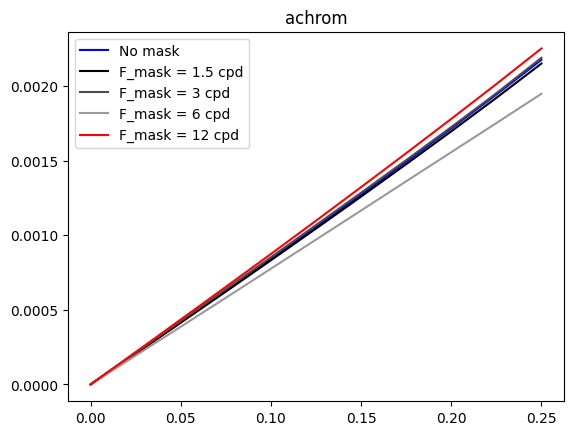

In [19]:
plot_diffs(diffs_low)

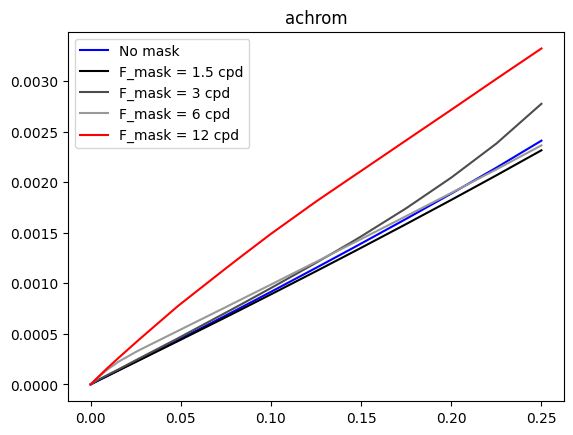

In [20]:
plot_diffs(diffs_high)

In [ ]:
diffs_low_s = np.array([a for a in diffs_low["achrom"].values()])
diffs_low_s.shape

(6, 20)

In [ ]:
calculate_spearman(diffs_low_s, ideal_ordering=[0,4,5,3,2,1])

{'spearman': np.float64(-0.35714285714285715),
 'kendall': np.float64(-0.3108333333333333),
 'pearson': np.float64(-0.3571428571428571)}

In [28]:
diffs_high_s = np.array([a for a in diffs_high["achrom"].values()])
diffs_high_s.shape

(6, 20)

In [29]:
calculate_spearman(diffs_high_s, ideal_ordering=[0,1,2,3,5,4])

{'spearman': np.float64(-0.7028571428571428),
 'kendall': np.float64(-0.5936666666666667),
 'pearson': np.float64(-0.7028571428571427)}